In [2]:
a=2

In [3]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


In [36]:
class State(TypedDict):
     # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [5]:
graph_builder

In [6]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [7]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

llm = ChatGroq(model="llama3-8b-8192")

In [8]:
llm = init_chat_model("groq:llama3-8b-8192")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000023E08AB7C20>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000023E09263FE0>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [9]:
# Node Functionality
def chatbot(state:State):
    return {"messages": [llm.invoke(state["messages"])]}


In [10]:
graph_builder = StateGraph(State)
# adding node
graph_builder.add_node("llmchatbot", chatbot)
#adding edge
graph_builder.add_edge(START, "llmchatbot")
graph_builder.add_edge("llmchatbot", END)

#Compile the Graph
graph = graph_builder.compile()




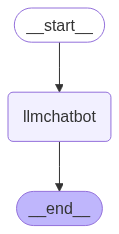

In [11]:
# visualize the graph
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))

except Exception as e:
    pass


In [24]:
graph.invoke("Hi")

InvalidUpdateError: Expected dict, got Hi
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_GRAPH_NODE_RETURN_VALUE

In [25]:
response = graph.invoke({"messages":"Hi"})

In [26]:
response["messages"]

[HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='8ed6867e-b9cf-4814-b155-a2de4554af4b'),
 AIMessage(content="Hi! It's nice to meet you. Is there something I can help you with, or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 11, 'total_tokens': 37, 'completion_time': 0.025317621, 'prompt_time': 0.002079913, 'queue_time': 0.19355011, 'total_time': 0.027397534}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_24ec19897b', 'finish_reason': 'stop', 'logprobs': None}, id='run--bb57214e-b6fd-492f-8517-6f7f05679669-0', usage_metadata={'input_tokens': 11, 'output_tokens': 26, 'total_tokens': 37})]

In [27]:
response["messages"][-1]

AIMessage(content="Hi! It's nice to meet you. Is there something I can help you with, or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 11, 'total_tokens': 37, 'completion_time': 0.025317621, 'prompt_time': 0.002079913, 'queue_time': 0.19355011, 'total_time': 0.027397534}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_24ec19897b', 'finish_reason': 'stop', 'logprobs': None}, id='run--bb57214e-b6fd-492f-8517-6f7f05679669-0', usage_metadata={'input_tokens': 11, 'output_tokens': 26, 'total_tokens': 37})

In [28]:
response["messages"][-1].content

"Hi! It's nice to meet you. Is there something I can help you with, or would you like to chat?"

In [29]:
for event in graph.stream({"messages":"Hi"}):
    print(event)

{'llmchatbot': {'messages': [AIMessage(content="Hi! It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 11, 'total_tokens': 36, 'completion_time': 0.02429205, 'prompt_time': 0.002098724, 'queue_time': 0.194328772, 'total_time': 0.026390774}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_24ec19897b', 'finish_reason': 'stop', 'logprobs': None}, id='run--9401d572-4083-4650-bbb8-d530fc1a2fe0-0', usage_metadata={'input_tokens': 11, 'output_tokens': 25, 'total_tokens': 36})]}}


In [30]:
for event in graph.stream({"messages":"Hi"}):
    for value in event.values():
        print(value)

{'messages': [AIMessage(content="Hi! It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 11, 'total_tokens': 36, 'completion_time': 0.024167033, 'prompt_time': 0.002618905, 'queue_time': 0.203269448, 'total_time': 0.026785938}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_24ec19897b', 'finish_reason': 'stop', 'logprobs': None}, id='run--586e5b8c-0594-4e0f-b219-acd8570b5fee-0', usage_metadata={'input_tokens': 11, 'output_tokens': 25, 'total_tokens': 36})]}


In [31]:
for event in graph.stream({"messages":"Hi"}):
    for value in event.values():
        print(value["messages"][-1].content)

Hi! It's nice to meet you. Is there something I can help you with or would you like to chat?


CHATBOT WITH TOOL

In [14]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=2)
tool.invoke("what is langgraph")

d:\Jeevan\Agentic_AI_Basics\AgenticLangGraph-1\.venv\Lib\site-packages\langchain_tavily\tavily_crawl.py:76: SyntaxWarning: invalid escape sequence '\.'
  description="""Regex patterns to select only URLs from specific domains or subdomains.
d:\Jeevan\Agentic_AI_Basics\AgenticLangGraph-1\.venv\Lib\site-packages\langchain_tavily\tavily_crawl.py:95: SyntaxWarning: invalid escape sequence '\.'
  description="""Regex patterns to exclude URLs from specific domains or subdomains.
d:\Jeevan\Agentic_AI_Basics\AgenticLangGraph-1\.venv\Lib\site-packages\langchain_tavily\tavily_crawl.py:233: SyntaxWarning: invalid escape sequence '\.'
  """Regex patterns to select only URLs from specific domains or subdomains.
d:\Jeevan\Agentic_AI_Basics\AgenticLangGraph-1\.venv\Lib\site-packages\langchain_tavily\tavily_crawl.py:243: SyntaxWarning: invalid escape sequence '\.'
  """
d:\Jeevan\Agentic_AI_Basics\AgenticLangGraph-1\.venv\Lib\site-packages\langchain_tavily\tavily_map.py:76: SyntaxWarning: invalid esca

{'query': 'what is langgraph',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
   'title': 'LangGraph Tutorial: What Is LangGraph and How to Use It?',
   'content': 'LangGraph is a library within the LangChain ecosystem that provides a framework for defining, coordinating, and executing multiple LLM agents (or chains) in a structured and efficient manner. By managing the flow of data and the sequence of operations, LangGraph allows developers to focus on the high-level logic of their applications rather than the intricacies of agent coordination. Whether you need a chatbot that can handle various types of user requests or a multi-agent system that performs complex tasks, LangGraph provides the tools to build exactly what you need. LangGraph significantly simplifies the development of complex LLM applications by providing a structured framework for managing state and coordinating agent interaction

In [15]:
##custom function
def multiply(a:int, b:int) -> int:
    """multiplt a and b
    Args:
    a (int): first int
    b (int): second int

    Returns:
    int: output int
    """

In [16]:
tools = [tool, multiply]

In [17]:
llm_with_tool = llm.bind_tools(tools)

In [18]:
llm_with_tool

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000023E08AB7C20>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000023E09263FE0>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A list 

In [ ]:
##stateGraph
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from IPython.display import Image, display


##Node Definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

##Graph
builder = StateGraph(State)
builder.add_node(START, "tool calling llm")
builder.add_node("tool calling llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm", 
    #If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    #If the latest message (result) from assistant is not a tool call -> tools_condition routes to END
    tools_condition 
    )
builder.add_edge("tools", END)

#Compile the Graph
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))



ValueError: Found edge starting at unknown node 'tool_calling_llm'